In [1]:

# Now we are checking annual average temperature


import pandas as pd
df = pd.read_csv('clean_temperature.csv', parse_dates=['DATE'])


In [2]:
df['YEAR']=df['DATE'].dt.year

annual = df.groupby('YEAR')['TAVG'].mean().reset_index()
annual.head()

,YEAR,TAVG
0,1945,14.419399
1,1946,12.582471
2,1947,13.479032
3,1948,12.633470
4,1949,12.620959


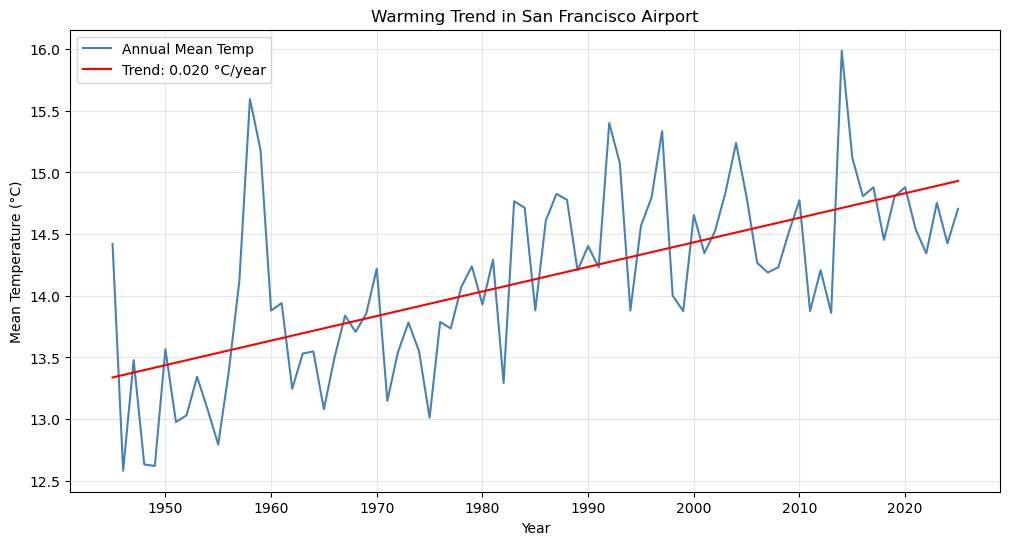

In [46]:


import matplotlib.pyplot as plt
import numpy as np

x = annual['YEAR']
y = annual['TAVG']

# Linear trend graphing 

coef=np.polyfit(x, y, 1)
trend = coef[0] * x + coef[1]

plt.figure(figsize=(12,6))
plt.plot(x, y, label='Annual Mean Temp', color='steelblue')
plt.plot(x, trend, label = f"Trend: {coef[0]:.3f} °C/year", color='red')
plt.xlabel("Year")
plt.ylabel("Mean Temperature (°C)")
plt.title("Warming Trend in San Francisco Airport")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [5]:
rate = coef[0]*10 #per decade
rate

0.19903466583077878

In [45]:
# now we are checking ONI to see the influence of it on annual avg temp 

import pandas as pd
from datetime import datetime
import numpy as np


path = "/Users/aeri/Desktop/Climate Risk/MINIPROJECT/nina3.anom.csv"

df = pd.read_csv(path)

# keep only first two columns (NOAA files are usually: Date + Value)
df = df.iloc[:, :2].copy()
df.columns = ["date", "nino3"]

# Parse date (fix the 2048/2049 bug by subtracting 100 years when it happens)
dt = pd.to_datetime(df["date"].astype(str).str.strip(), errors="coerce")
now_year = datetime.now().year
dt = dt.where(dt.dt.year <= now_year, dt - pd.DateOffset(years=100))

df["date"] = dt

# Numeric + missing values
df["nino3"] = pd.to_numeric(df["nino3"], errors="coerce")
df.loc[df["nino3"].isin([-9999, -99.99]), "nino3"] = np.nan

# Clean
df = df.dropna(subset=["date", "nino3"]).sort_values("date").reset_index(drop=True)

# Phase
df["phase"] = np.select( 
    [df["nino3"] >= 0.5, df["nino3"] <= -0.5],
    ["elnino", "lanina"],
    default = "neutral"

)
df.head()

,date,nino3,phase
0,1950-01-01,-2.10,lanina
1,1950-02-01,-1.52,lanina
2,1950-03-01,-0.84,lanina
3,1950-04-01,-1.14,lanina
4,1950-05-01,-1.57,lanina


In [54]:
thr = 0.5
k = 5

#3-month running mean (centered optional)
df["nino3_rm3"] = df["nino3"].rolling(3).mean()

is_en = df["nino3_rm3"] >= thr
is_ln = df["nino3_rm3"] <= -thr

# 연속 구간 그룹 id (True/False 바뀔 때마다 새 그룹)
en_grp = (is_en != is_en.shift()).cumsum()
ln_grp = (is_ln != is_ln.shift()).cumsum()

# 각 그룹의 길이(구간 길이)
en_len = is_en.groupby(en_grp).transform("sum")   # True인 달 개수
ln_len = is_ln.groupby(ln_grp).transform("sum")

# k 이상인 구간이면 구간 전체 True
df["elnino_5mo_rm3"] = is_en & (en_len >= k)
df["lanina_5mo_rm3"] = is_ln & (ln_len >= k)



df["phase_5mo_rm3"] = np.select(
    [df["elnino_5mo_rm3"], df["lanina_5mo_rm3"]],
    ["elnino", "lanina"],
    default="neutral"
)


In [56]:
df.head(20)

,date,nino3,phase,nino3_rm3,elnino_5mo_rm3,lanina_5mo_rm3,phase_5mo_rm3
0,1950-01-01,-2.10,lanina,NaN,False,False,neutral
1,1950-02-01,-1.52,lanina,NaN,False,False,neutral
2,1950-03-01,-0.84,lanina,-1.486667,False,True,lanina
3,1950-04-01,-1.14,lanina,-1.166667,False,True,lanina
4,1950-05-01,-1.57,lanina,-1.183333,False,True,lanina
5,1950-06-01,-1.11,lanina,-1.273333,False,True,lanina
6,1950-07-01,-0.90,lanina,-1.193333,False,True,lanina
7,1950-08-01,-0.65,lanina,-0.886667,False,True,lanina
8,1950-09-01,-0.89,lanina,-0.813333,False,True,lanina
9,1950-10-01,-0.81,lanina,-0.783333,False,True,lanina


In [57]:
out = df.copy()

# 최종 phase 컬럼 확정
out["phase_oni"] = out["phase_5mo_rm3"]

# 필요한 컬럼만 저장
out = out[["date", "nino3", "nino3_rm3", "phase_oni"]].copy()

# date 정렬 + 인덱스 리셋
out = out.sort_values("date").reset_index(drop=True)
# export
out_path = "/Users/aeri/Desktop/Climate Risk/MINIPROJECT/oni_clean.csv"
out.to_csv(out_path, index=False)

out.head()

,date,nino3,nino3_rm3,phase_oni
0,1950-01-01,-2.10,NaN,neutral
1,1950-02-01,-1.52,NaN,neutral
2,1950-03-01,-0.84,-1.486667,lanina
3,1950-04-01,-1.14,-1.166667,lanina
4,1950-05-01,-1.57,-1.183333,lanina


In [65]:


# now we are highlighting this on monthly avg Tmax
# but first, we need to calculate monthly avg Tmax

oni = pd.read_csv("/Users/aeri/Desktop/Climate Risk/MINIPROJECT/oni_clean.csv", parse_dates=["date"])
temp = pd.read_csv("/Users/aeri/Desktop/Climate Risk/MINIPROJECT/clean_temperature.csv", parse_dates=["DATE"])



In [66]:
temp = temp.sort_values("DATE")

# Monthly aggregation: values are monthly means.
# DATE is labeled as month-start (MS) for alignment/merging with other monthly series (e.g., ONI).


monthly_temp = (
    temp.set_index("DATE")
    .resample("MS")
    [["TAVG", "TMAX", "TMIN"]]
    .mean()
    .reset_index()

)



In [62]:
monthly_temp.head()

,DATE,TAVG,TMAX,TMIN
0,1945-07-01,16.295161,20.664516,11.925806
1,1945-08-01,15.208065,19.838710,10.577419
2,1945-09-01,16.916667,22.626667,11.206667
3,1945-10-01,15.516667,20.060000,10.973333
4,1945-11-01,12.188333,16.310000,8.066667


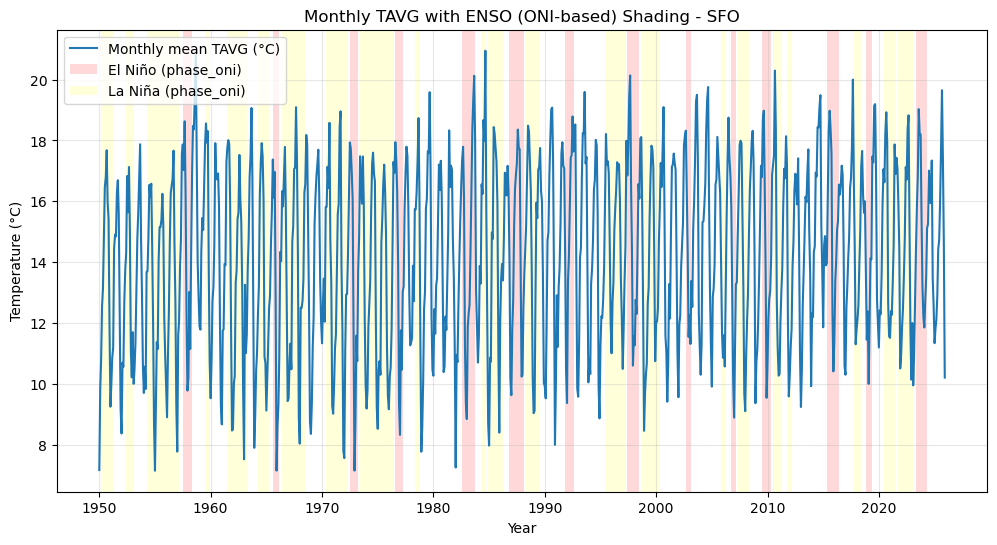

In [76]:
from matplotlib.patches import Patch


# Rename for clean merge key consistency
monthly_temp = monthly_temp.rename(columns={"DATE": "date"})


# plotting monthly avg temp with ONI data

m = monthly_temp.rename(columns={"DATE":"date"}).merge(
    oni[["date","phase_oni"]],
    on="date",
    how="left"
)

# 1) date to datatime
m = m.copy()
m["date"] = pd.to_datetime(m["date"])

# 2) ONI starts in 1950, so we analyze 1950+ only.
m = m.sort_values("date")
m = m[m["date"] >= "1950-01-01"].copy()

# 3) base line plot (Monthly TAVG)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(m["date"], m["TAVG"], label="Monthly mean TAVG (°C)")


# 4) Oni shade (El Niño=red, La Ñina=yellow)
shade_map = {
    "elnino": {"color": "red", "alpha": 0.15},
    "lanina": {"color": "yellow", "alpha": 0.15},
}

# 5) elnino/lanina into window
phase = m["phase_oni"].fillna("neutral")
is_event = phase.isin(shade_map.keys())

phase.head()
is_event.head()

# consequetive id increases number of group
run_id = (phase != phase.shift()).cumsum()

# 6) axvspan shade
for _, sub in m[is_event].groupby(run_id):
    ph = phase.loc[sub.index[0]] # phase for this window 
    start = sub["date"].iloc[0]
    end = sub["date"].iloc[-1] + pd.offsets.MonthBegin(1)
    ax.axvspan(start, end, 
              color=shade_map[ph]["color"],
              alpha=shade_map[ph]["alpha"],
              linewidth=0)

# axis, title, grid
ax.set_title("Monthly TAVG with ENSO (ONI-based) Shading - SFO")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.grid(alpha=0.3)
    
# legend 
legend_items = [
    ax.lines[0],
    Patch(facecolor="red", alpha=0.15, label="El Niño (phase_oni)"),
    Patch(facecolor="yellow", alpha=0.15, label="La Niña (phase_oni)"),
]

ax.legend(handles=legend_items, loc="upper left")

plt.show()

In [79]:
df.head()


,date,nino3,phase,nino3_rm3,elnino_5mo_rm3,lanina_5mo_rm3,phase_5mo_rm3
0,1950-01-01,-2.10,lanina,NaN,False,False,neutral
1,1950-02-01,-1.52,lanina,NaN,False,False,neutral
2,1950-03-01,-0.84,lanina,-1.486667,False,True,lanina
3,1950-04-01,-1.14,lanina,-1.166667,False,True,lanina
4,1950-05-01,-1.57,lanina,-1.183333,False,True,lanina


In [81]:
monthly_temp.head()

,date,TAVG,TMAX,TMIN
0,1945-07-01,16.295161,20.664516,11.925806
1,1945-08-01,15.208065,19.838710,10.577419
2,1945-09-01,16.916667,22.626667,11.206667
3,1945-10-01,15.516667,20.060000,10.973333
4,1945-11-01,12.188333,16.310000,8.066667


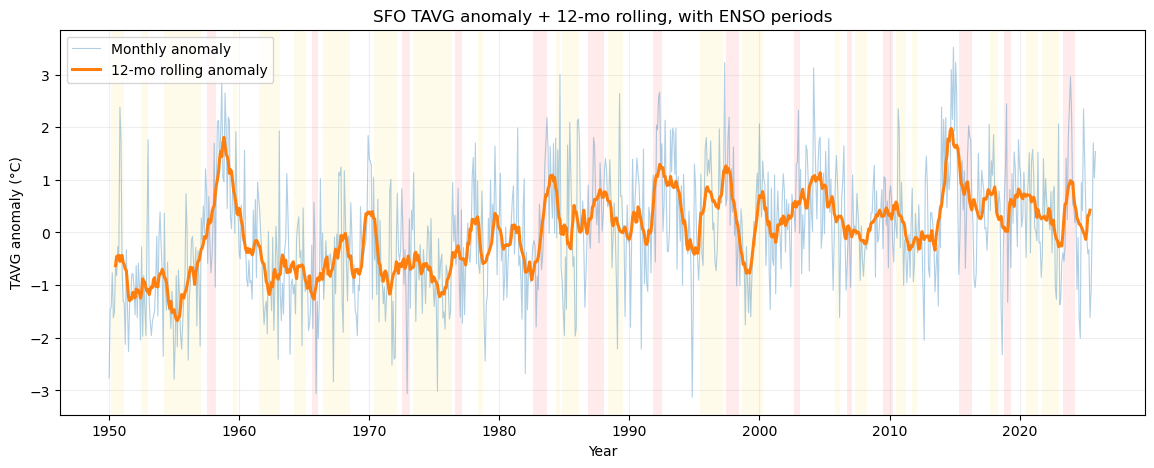

,date,TAVG,TMAX,TMIN,nino3,nino3_rm3,phase_oni,month,TAVG_anom,anom_12m
0,1950-01-01,7.175806,10.983871,3.367742,-2.10,NaN,neutral,1,-2.762797,NaN
1,1950-02-01,9.873214,13.896429,5.850000,-1.52,NaN,neutral,2,-1.458335,NaN
2,1950-03-01,10.766129,15.148387,6.383871,-0.84,-1.486667,lanina,3,-1.423132,NaN
3,1950-04-01,12.550000,18.250000,6.850000,-1.14,-1.166667,lanina,4,-0.767544,NaN
4,1950-05-01,13.141935,18.374194,7.909677,-1.57,-1.183333,lanina,5,-1.622050,NaN


In [85]:

## TODO: 12-mo rolling anomaly + ONI overlay (monthly)

m2 = monthly_temp.copy()
m2['date'] = pd.to_datetime(m2['date'])

enso2 = oni.copy()
enso2['date'] = pd.to_datetime(enso2['date'])

# merge temp + ONI on date

combo2 = pd.merge (m2, enso2, on='date', how='inner').sort_values('date')

# de-seasonalize : make anomalies

combo2['month'] = combo2['date'].dt.month
clim2 = combo2.groupby('month')['TAVG'].mean()
combo2['TAVG_anom'] = combo2['TAVG'] - combo2['month'].map(clim2)

# Smooth: 12-month rolling mean of anomaly
combo2['anom_12m'] = combo2['TAVG_anom'].rolling(12, center=True).mean()

# --- masks from phase_oni ---
mask_el = combo2['phase_oni'].astype(str).str.lower().eq('elnino')
mask_la = combo2['phase_oni'].astype(str).str.lower().eq('lanina')


# Shade contiguous ENSO spans 

def shade_spans(ax, dates, mask, color, alpha=0.10):
    in_span = False
    start = None
    prev = dates.iloc[0]

    for d, flag in zip(dates, mask):
        if flag and not in_span:
            start = d
            in_span = True

        if in_span and (not flag):
            ax.axvspan(start, prev, color=color, alpha=alpha, linewidth=0)
            in_span = False

        prev = d

    if in_span:
        ax.axvspan(start, prev, color=color, alpha=alpha, linewidth=0)



# Plot


fig, ax = plt.subplots(figsize=(14,5))

ax.plot(combo2['date'], combo2['TAVG_anom'], linewidth=0.8, alpha=0.35, label='Monthly anomaly')
ax.plot(combo2['date'], combo2['anom_12m'], linewidth=2.2, label='12-mo rolling anomaly')

# Use your existing boolean columns from df
shade_spans(ax, combo2['date'], mask_el, color='red',  alpha=0.08)
shade_spans(ax, combo2['date'], mask_la, color='gold', alpha=0.08)

ax.set_title("SFO TAVG anomaly + 12-mo rolling, with ENSO periods")
ax.set_xlabel("Year")
ax.set_ylabel("TAVG anomaly (°C)")
ax.grid(True, alpha=0.2)
ax.legend(loc="upper left")

plt.show()

combo2.head()